# Earthquake Damage Modelling : Model Preparation

In [349]:
#Importing necessary Libraries
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,accuracy_score,f1_score,precision_score,recall_score
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import precision_score,recall_score,auc
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor,StackingCVRegressor

In [350]:
import warnings
warnings.filterwarnings("ignore")

In [351]:
train_data=pd.read_csv('train_values.csv')
test_data=pd.read_csv('test_values.csv')
train_y=pd.read_csv('train_labels.csv')
test_y=pd.read_csv('test_labels.csv')

In [352]:
print('Training data shape:',train_data.shape)
print('Test data shape:',test_data.shape)

Training data shape: (609674, 42)
Test data shape: (152419, 42)


## Data Preparation for Models:

In [353]:
train_data.damage_grade=train_data.damage_grade.replace({1:'Low',2:'Medium',3:'High'})
test_data.damage_grade=test_data.damage_grade.replace({1:'Low',2:'Medium',3:'High'})

In [354]:
train=train_data

In [6]:
train_high=train[train.damage_grade=='High']
train_medium=train[train.damage_grade=='Medium']
train_low=train[train.damage_grade=='Low']

In [7]:
train_high=train_high.sample(100000)
train_medium=train_medium.sample(100000)
train_low=train_low.sample(100000)

In [8]:
train = pd.concat([train_high, train_medium,train_low], ignore_index=True, sort =False)
train=train.sample(frac=1)
train.head(5)

,building_id,geo1,geo2,geo3,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
142330,241409000441,24,2408,240810,2,1,44,470,16,12,...,0,0,0,0,0,0,0,0,0,0
98280,247209000941,24,2410,241001,3,3,82,500,24,24,...,0,0,0,0,0,0,0,0,0,0
209806,125403000181,12,1207,120702,2,2,26,400,14,14,...,0,0,0,0,0,0,0,0,0,0
282600,311103002231,31,3104,310415,1,1,12,350,10,10,...,0,0,0,0,0,0,0,0,0,0
186092,312404002471,31,3110,311008,1,1,5,186,6,6,...,0,0,0,0,0,0,0,0,0,0


In [355]:
train=train.sample(300000)

#### Train-Test-Validation split:

In [356]:
train_=train

In [357]:
y_train=train.damage_grade
train=train.drop('damage_grade',axis=1)

In [358]:
y_test=test_data.damage_grade
x_test=test_data.drop('damage_grade',axis=1)

In [359]:
x_train,x_cv,y_train,y_cv=train_test_split(train,y_train,stratify=y_train,test_size=0.3)

#### Preprocessing:

In [12]:
print('Data in Train dataset:',len(x_train))
print('Data in Test dataset:',len(x_test))
print('Data in CV dataset:',len(x_cv))

Data in Train dataset: 210000
Data in Test dataset: 152419
Data in CV dataset: 90000


In [360]:
# utility function to preprocess data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
def preprocess_num_data(train_data,cv_data,test_data):
    std=Normalizer()
    std.fit(train_data)
    transformed_input=std.transform(train_data)
    transformed_cv=std.transform(cv_data)
    transformed_test=std.transform(test_data)
    return transformed_input,transformed_cv,transformed_test
def preprocess_cat_data(train_data,cv_data,test_data):
    std=LabelEncoder()
    for col in train_data.columns:
        col_list_train=list(map(str,train_data[col].values))
        #print(col_list_train)
        col_list_cv=list(map(str,cv_data[col].values))
        col_list_test=list(map(str,test_data[col].values))
        std.fit(col_list_train)
        col_list_train=std.transform(col_list_train)
        col_list_test=std.transform(col_list_test)
        col_list_cv=std.transform(col_list_cv)
        train_data[col]=col_list_train
        test_data[col]=col_list_test
        cv_data[col]=col_list_cv
    return train_data,cv_data,test_data
    

In [361]:
num_data=['geo1', 'geo2', 'geo3',
       'count_floors_pre_eq','count_floors_post_eq', 'age_building','plinth_area_sq_ft','count_families',
         'height_ft_pre_eq', 'height_ft_post_eq']
cat_data=['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position','legal_ownership_status',
       'plan_configuration'] 
bin_data=['has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
        'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

In [362]:
# filtering numerical data
num_train=x_train[num_data]
num_test=x_test[num_data]
num_cv=x_cv[num_data]
# filtering categorical data
cat_train=x_train[cat_data]
cat_test=x_test[cat_data]
cat_cv=x_cv[cat_data]
# filtering binary data
bin_train=x_train[bin_data]
bin_test=x_test[bin_data]
bin_cv=x_cv[bin_data]

In [363]:
num_train,num_cv,num_test=preprocess_num_data(num_train,num_cv,num_test)
cat_train,cat_cv,cat_test=preprocess_cat_data(cat_train,cat_cv,cat_test)
bin_train,bin_cv,bin_test=preprocess_cat_data(bin_train,bin_cv,bin_test)

In [364]:
from scipy.sparse import hstack
train_data_final=hstack((num_train,cat_train,bin_train)).tocsr()
test_data_final=hstack((num_test,cat_test,bin_test)).tocsr()
cv_data_final=hstack((num_cv,cat_cv,bin_cv)).tocsr()

In [365]:
# shape of final data matrixes
print(train_data_final.shape)
print(test_data_final.shape)
print(cv_data_final.shape)

(210000, 40)
(152419, 40)
(90000, 40)


In [366]:
#function to plot confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [159]:
# function to run any model
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    
    # calculate overall accuracty of the model
    print('---------Performance Score--------------')
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    precision=precision_score(y_true=y_test, y_pred=y_pred,average='micro')
    recall=recall_score(y_true=y_test, y_pred=y_pred,average='micro')
    micro_f1=f1_score(y_true=y_test, y_pred=y_pred,average='micro')
    print('\n Micro F1:{}'.format(micro_f1))
    print('\n Precision:{}'.format(precision))
    print('\n Recall:{}'.format(recall))
    print('\n Accuracy:{}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results,model
    
    

In [160]:
def predict_test_f1(model,x_test,y_test):
    y_pred=model.predict(x_test)
    micro_f1=f1_score(y_true=y_test, y_pred=y_pred,average='micro')
    print('\n Micro F1 Score of Test Data:{}'.format(micro_f1))
    

# Model Preparation:

In [91]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.externals import joblib 
import random

In [313]:
labels=['Low','Medium','High']

<h4>Base line model with random prediction:</h4>

In [399]:
y_pred_random=[]
for i in range(cv_data_final.shape[0]):
    y_pred_random.append(random.randint(1,3))
#y_pred_random=y_pred_random.map({1:'Low',2:'Medium',3:'High'})
y_cv_truth=y_cv.map({'Low':1,'Medium':2,'High':3})
score=f1_score(y_pred_random,y_cv_truth,average='micro')
print('F1 Score of random model on CV data is:',score)

F1 Score of random model on CV data is: 0.33011111111111113


We will try to beat this baseline(random) score using machine learning models

### Logistic Regression:

training the model..
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.7min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:14:09.918197


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.014962


---------Performance Score--------------

 Micro F1:0.6909111111111111

 Precision:0.6909111111111111

 Recall:0.6909111111111111

 Accuracy:0.6909111111111111

--------------------
| Confusion Matrix |

 [[45402  2790  6144]
 [ 4286 11690  3626]
 [ 7430  3542  5090]]


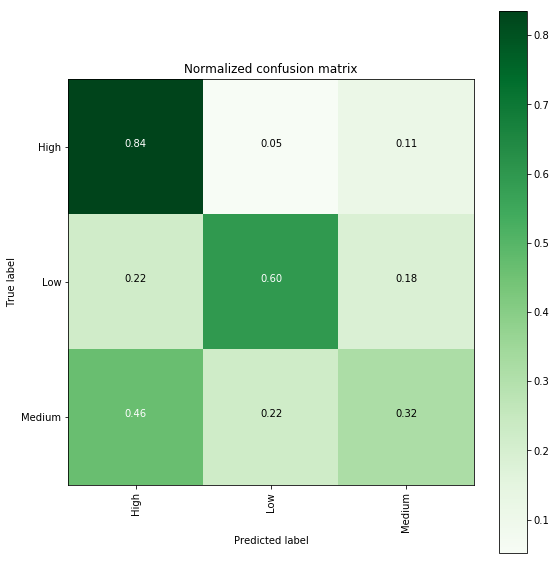

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

        High       0.79      0.84      0.81     54336
         Low       0.65      0.60      0.62     19602
      Medium       0.34      0.32      0.33     16062

   micro avg       0.69      0.69      0.69     90000
   macro avg       0.60      0.58      0.59     90000
weighted avg       0.68      0.69      0.69     90000



In [161]:

# start Grid search
parameters = {'C':[0.01, 0.1, 1,5, 10], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression(class_weight='balanced')
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results,lr_model =  perform_model(log_reg_grid, train_data_final, y_train, cv_data_final, y_cv, class_labels=labels)


In [314]:
predict_test_f1(lr_model,test_data_final,y_test)


 Micro F1 Score of Test Data:0.6910949422316115


In [164]:
joblib.dump(lr_model,'log_reg_model.pkl')


['log_reg_model.pkl']

### Linear SVM with Nystroem approximation:

training the model..
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.8min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:05:08.795514


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.031712


---------Performance Score--------------

 Micro F1:0.6818

 Precision:0.6818

 Recall:0.6818

 Accuracy:0.6818

--------------------
| Confusion Matrix |

 [[32960  2578   712]
 [ 5205  7569   284]
 [ 8004  2309   379]]


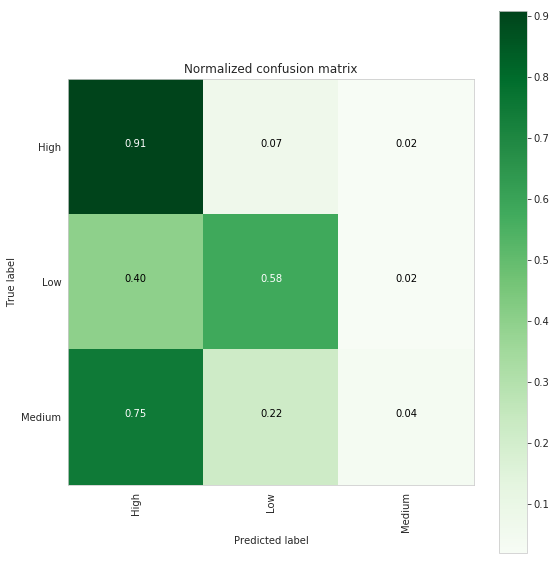

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

        High       0.71      0.91      0.80     36250
         Low       0.61      0.58      0.59     13058
      Medium       0.28      0.04      0.06     10692

   micro avg       0.68      0.68      0.68     60000
   macro avg       0.53      0.51      0.49     60000
weighted avg       0.61      0.68      0.62     60000



In [39]:
from sklearn.kernel_approximation import Nystroem
params = {'C':[0.125, 0.5, 1, 2, 8]}
feature_map_nystroem = Nystroem(gamma=.2,random_state=1)
data_transformed = feature_map_nystroem.fit_transform(train_data_final)
cv_transformed=feature_map_nystroem.transform(cv_data_final)
linear_svc=LinearSVC(tol=0.00005,class_weight='balanced')
grid=GridSearchCV(linear_svc,param_grid=params,n_jobs=-1,verbose=1)
linear_svc_res,linear_svc_model=perform_model(grid,data_transformed, y_train, cv_transformed, y_cv, class_labels=labels)


In [75]:
test_transformed=feature_map_nystroem.transform(test_data_final)
#y_test=y_test.map({1:'Low',2:'Medium',3:'High'})
predict_test_f1(linear_svc_model,test_transformed,y_test)


 Micro F1 Score of Test Data:0.681935979110216


### Random Forest Classifier:

training the model..
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.2min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:05:44.665616


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:01.058197


---------Performance Score--------------

 Micro F1:0.6582888888888889

 Precision:0.6582888888888889

 Recall:0.6582888888888889

 Accuracy:0.6582888888888889

--------------------
| Confusion Matrix |

 [[34620  2015 17675]
 [  170 12200  7170]
 [  425  3299 12426]]


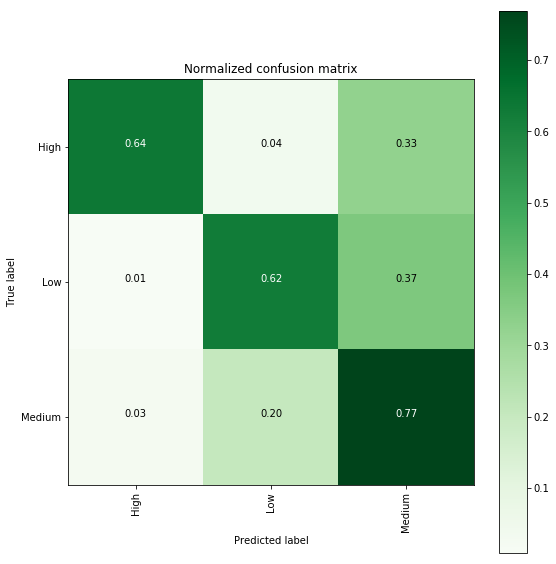

-------------------------
| Classifiction Report |
              precision    recall  f1-score   support

        High       0.98      0.64      0.77     54310
         Low       0.70      0.62      0.66     19540
      Medium       0.33      0.77      0.47     16150

   micro avg       0.66      0.66      0.66     90000
   macro avg       0.67      0.68      0.63     90000
weighted avg       0.80      0.66      0.69     90000



In [105]:
from sklearn.ensemble import RandomForestClassifier
params = {'max_depth':[2,3,5,7],'n_estimators':[20,50,100,200]}
rf=RandomForestClassifier(class_weight='balanced')
grid=GridSearchCV(rf,param_grid=params,n_jobs=-1,verbose=1)
rf_res,rf_model=perform_model(grid,train_data_final, y_train,cv_data_final, y_cv, class_labels=labels)

In [140]:
predict_test_f1(rf_model,test_data_final,y_test)


 Micro F1 Score of Test Data:0.6559418445206963


In [141]:
joblib.dump(rf_model,'random_forest_model_65.pkl')

['random_forest_model_65.pkl']

### Multi Class LightGBM with custom metric :

In [197]:
x_train_=x_train.drop('building_id',axis=1)
x_test_=x_test.drop('building_id',axis=1)
x_cv_=x_cv.drop('building_id',axis=1)
y_train_=y_train.map({'Low':0,'Medium':1,'High':2})
y_test_=y_test.map({'Low':0,'Medium':1,'High':2})
y_cv_=y_cv.map({'Low':0,'Medium':1,'High':2})

<h4>Utility functions for Light GBM</h4>

In [109]:
import lightgbm as lgbm
from sklearn.preprocessing import LabelBinarizer
#https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
def predict_lgbm(lgb_model,x_test,y_test):
    lgb_prediction = lgb_model.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    cm = metrics.confusion_matrix(y_test_, lgb_prediction)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
    lgb_F1 = f1_score(lgb_prediction, y_test, average = 'micro')
    print("The Light GBM F1 is", lgb_F1)
    
def preprocess_cat_data_lgbm(train_data,cols):
    #print(cols)
    for col in train_data.columns:
        if(col in cols):
            std=LabelEncoder() 
            temp=list(train_data[col].values)
            res=std.fit_transform(temp)
            train_data[col]=res
    return train_data

def lgb_f1_score(y_pred,data):
    y_true = data.get_label().astype('int')
    #F1 score not improving in multiclass lgbm custom metric:https://github.com/Microsoft/LightGBM/issues/1483
    y_pred =y_pred.reshape((3,-1)).argmax(axis=0) 
    y_pred=np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred,average='micro'), True

def predict_lgbm(lgb_model,x_test,y_test):
    lgb_prediction = lgb_model.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    lgb_F1 = f1_score(lgb_prediction, y_test, average = 'micro')
    print("The Light GBM F1 is", lgb_F1)

In [378]:
x_train_=preprocess_cat_data_lgbm(x_train,cols=cat_data)
x_cv_=preprocess_cat_data_lgbm(x_cv,cols=cat_data)
x_test_=preprocess_cat_data_lgbm(x_test,cols=cat_data)

<h4>Parameter Tuning: Learning rate</h4>

<h4>Learning rate=0.005</h4>

In [96]:
train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'learning_rate': 0.005,
    'max_depth': 5,
    'num_leaves': 20,
    'is_unbalanced':True,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5}

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],
                       num_boost_round=15000,
                       feval=lgb_f1_score,
                       verbose_eval=500,
                       early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds.
[500]	train's multi_logloss: 0.593373	train's f1: 0.727897	val's multi_logloss: 0.592856	val's f1: 0.728293
[1000]	train's multi_logloss: 0.561057	train's f1: 0.736943	val's multi_logloss: 0.561442	val's f1: 0.737293
[1500]	train's multi_logloss: 0.549571	train's f1: 0.745046	val's multi_logloss: 0.550784	val's f1: 0.74504
[2000]	train's multi_logloss: 0.541013	train's f1: 0.751097	val's multi_logloss: 0.543432	val's f1: 0.74996
[2500]	train's multi_logloss: 0.534052	train's f1: 0.755594	val's multi_logloss: 0.537693	val's f1: 0.754653
[3000]	train's multi_logloss: 0.528326	train's f1: 0.759697	val's multi_logloss: 0.533253	val's f1: 0.75848
[3500]	train's multi_logloss: 0.523082	train's f1: 0.763777	val's multi_logloss: 0.529267	val's f1: 0.7616
[4000]	train's multi_logloss: 0.518158	train's f1: 0.767109	val's multi_logloss: 0.525612	val's f1: 0.763773
[4500]	train's multi_logloss: 0.51355	train's f1: 0.770297	val's multi_

<h4>Learning rate=0.05</h4>

In [111]:
train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'learning_rate': 0.05,
    'max_depth': 5,
    'num_leaves': 20,
    'is_unbalanced':True,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5,
    'lambda_l2':0.01}

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],
                       num_boost_round=5000,
                       feval=lgb_f1_score,
                       verbose_eval=100,
                       early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds.
[100]	train's multi_logloss: 0.562457	train's f1: 0.735148	val's multi_logloss: 0.563661	val's f1: 0.735356
[200]	train's multi_logloss: 0.541719	train's f1: 0.750676	val's multi_logloss: 0.544627	val's f1: 0.749156
[300]	train's multi_logloss: 0.529074	train's f1: 0.758986	val's multi_logloss: 0.533966	val's f1: 0.755767
[400]	train's multi_logloss: 0.519332	train's f1: 0.765357	val's multi_logloss: 0.526204	val's f1: 0.761344
[500]	train's multi_logloss: 0.510985	train's f1: 0.770881	val's multi_logloss: 0.519891	val's f1: 0.765156
[600]	train's multi_logloss: 0.503724	train's f1: 0.775281	val's multi_logloss: 0.514693	val's f1: 0.7677
[700]	train's multi_logloss: 0.497769	train's f1: 0.778786	val's multi_logloss: 0.51065	val's f1: 0.77
[800]	train's multi_logloss: 0.492507	train's f1: 0.781652	val's multi_logloss: 0.5073	val's f1: 0.771944
[900]	train's multi_logloss: 0.487786	train's f1: 0.784181	val's multi_logloss: 0.

In [114]:
predict_lgbm(clf,x_test_,y_test_)

The Light GBM F1 is 0.7847971709563768


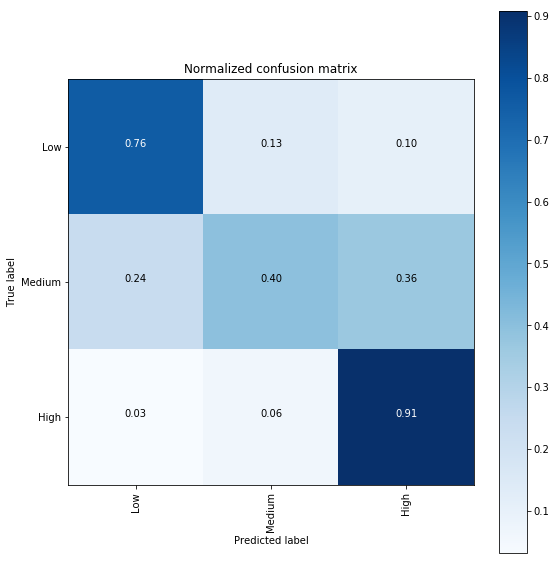

In [315]:
    lgb_prediction = clf.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    cm = metrics.confusion_matrix(y_test_, lgb_prediction)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')

In [135]:
joblib.dump(clf,'lgbm_model_78.pkl')

['lgbm_model_78.pkl']

<h4>Learning rate=0.10,bagging_fraction:0.7</h4>

In [35]:
train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'learning_rate': 0.10,
    'max_depth': 5,
    'num_leaves': 20,
    'is_unbalanced':True,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7}

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],
                       num_boost_round=5000,
                       feval=lgb_f1_score,
                       verbose_eval=100,
                       early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds.
[100]	train's multi_logloss: 0.541858	train's f1: 0.752583	val's multi_logloss: 0.544824	val's f1: 0.749173
[200]	train's multi_logloss: 0.518503	train's f1: 0.766451	val's multi_logloss: 0.527149	val's f1: 0.759893
[300]	train's multi_logloss: 0.502807	train's f1: 0.776126	val's multi_logloss: 0.516375	val's f1: 0.766667
[400]	train's multi_logloss: 0.490701	train's f1: 0.78264	val's multi_logloss: 0.509061	val's f1: 0.770213
[500]	train's multi_logloss: 0.480997	train's f1: 0.788074	val's multi_logloss: 0.503986	val's f1: 0.773347
[600]	train's multi_logloss: 0.472644	train's f1: 0.792817	val's multi_logloss: 0.500098	val's f1: 0.775213
[700]	train's multi_logloss: 0.465148	train's f1: 0.797017	val's multi_logloss: 0.496843	val's f1: 0.777
[800]	train's multi_logloss: 0.458807	train's f1: 0.80076	val's multi_logloss: 0.494501	val's f1: 0.777947
[900]	train's multi_logloss: 0.452532	train's f1: 0.804257	val's multi_logloss

<h4>Learning rate=0.005,max_depth=7</h4>

In [36]:
train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'learning_rate': 0.10,
    'max_depth': 7,
    'num_leaves': 20,
    'is_unbalanced':True,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7}

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],
                       num_boost_round=5000,
                       feval=lgb_f1_score,
                       verbose_eval=100,
                       early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds.
[100]	train's multi_logloss: 0.531448	train's f1: 0.758771	val's multi_logloss: 0.535439	val's f1: 0.754627
[200]	train's multi_logloss: 0.510563	train's f1: 0.771737	val's multi_logloss: 0.520742	val's f1: 0.764707
[300]	train's multi_logloss: 0.495702	train's f1: 0.779709	val's multi_logloss: 0.511796	val's f1: 0.769347
[400]	train's multi_logloss: 0.484187	train's f1: 0.786291	val's multi_logloss: 0.505858	val's f1: 0.772453
[500]	train's multi_logloss: 0.474263	train's f1: 0.79212	val's multi_logloss: 0.501383	val's f1: 0.774587
[600]	train's multi_logloss: 0.465534	train's f1: 0.797331	val's multi_logloss: 0.497922	val's f1: 0.77668
[700]	train's multi_logloss: 0.45777	train's f1: 0.801354	val's multi_logloss: 0.495301	val's f1: 0.778
[800]	train's multi_logloss: 0.451141	train's f1: 0.805057	val's multi_logloss: 0.493433	val's f1: 0.77868
[900]	train's multi_logloss: 0.444604	train's f1: 0.80888	val's multi_logloss: 0

#### LightGBM Evaluation:

In [53]:
predict_lgbm(clf,x_test_,y_test_)

The Light GBM F1 is 0.7837277504773027


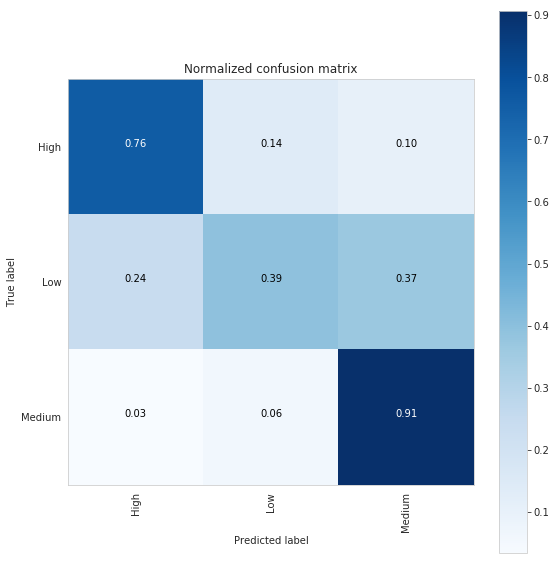

In [51]:
    lgb_prediction = clf.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    cm = metrics.confusion_matrix(y_test_, lgb_prediction)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')

<h4>Parameter Tuning: num_leaves</h4>

In [244]:
num_leaves=[10,20,30,40,50]
for n in num_leaves:
        train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
        test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
        cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)
        params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class':3,
        'learning_rate': 0.05,
        'max_depth': 5,
        'num_leaves': n,
        'is_unbalanced':True,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.5}
        print('Num leaves:',n)
        clf=lgbm.train(params,train_data_lgbm,valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],num_boost_round=500,
                       feval=lgb_f1_score,verbose_eval=100,early_stopping_rounds=50)
        print('---------------------------------------------------')


Num leaves: 10
Training until validation scores don't improve for 50 rounds.
[100]	train's multi_logloss: 0.567422	train's f1: 0.731926	val's multi_logloss: 0.569953	val's f1: 0.729507
[200]	train's multi_logloss: 0.548933	train's f1: 0.746137	val's multi_logloss: 0.552683	val's f1: 0.743453
[300]	train's multi_logloss: 0.539184	train's f1: 0.752286	val's multi_logloss: 0.544218	val's f1: 0.749027
[400]	train's multi_logloss: 0.531795	train's f1: 0.757229	val's multi_logloss: 0.538232	val's f1: 0.752653
[500]	train's multi_logloss: 0.525669	train's f1: 0.761429	val's multi_logloss: 0.53335	val's f1: 0.75632
Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.525669	train's f1: 0.761429	val's multi_logloss: 0.53335	val's f1: 0.75632
---------------------------------------------------
Num leaves: 20
Training until validation scores don't improve for 50 rounds.
[100]	train's multi_logloss: 0.562164	train's f1: 0.735674	val's multi_logloss: 0.565938	val's f1: 0.7

<h4>Parameter Tuning: max_depth</h4>

In [245]:
max_depth=[2,3,5,7]
for n in max_depth:
        train_data_lgbm = lgbm.Dataset(x_train_, label=y_train_,categorical_feature=cat_data)
        test_data_lgbm = lgbm.Dataset(x_test_, label=y_test_)
        cv_data_lgbm=lgbm.Dataset(x_cv_, label=y_cv_)
        params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class':3,
        'learning_rate': 0.05,
        'max_depth': n,
        'num_leaves': 40,
        'is_unbalanced':True,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.5}
        print('Num leaves:',n)
        clf=lgbm.train(params,train_data_lgbm,valid_sets=[cv_data_lgbm,train_data_lgbm],
                       valid_names=['val','train'],num_boost_round=5000,
                       feval=lgb_f1_score,verbose_eval=500,early_stopping_rounds=200)
        print('---------------------------------------------------')


Num leaves: 2
Training until validation scores don't improve for 200 rounds.
[500]	train's multi_logloss: 0.556905	train's f1: 0.740349	val's multi_logloss: 0.559254	val's f1: 0.737893
[1000]	train's multi_logloss: 0.543105	train's f1: 0.749726	val's multi_logloss: 0.546693	val's f1: 0.746947
[1500]	train's multi_logloss: 0.533597	train's f1: 0.756463	val's multi_logloss: 0.53806	val's f1: 0.752693
[2000]	train's multi_logloss: 0.527038	train's f1: 0.760697	val's multi_logloss: 0.532307	val's f1: 0.756653
[2500]	train's multi_logloss: 0.520838	train's f1: 0.764063	val's multi_logloss: 0.526819	val's f1: 0.760573
[3000]	train's multi_logloss: 0.516786	train's f1: 0.766349	val's multi_logloss: 0.523396	val's f1: 0.762933
[3500]	train's multi_logloss: 0.513335	train's f1: 0.768086	val's multi_logloss: 0.52069	val's f1: 0.763947
[4000]	train's multi_logloss: 0.510373	train's f1: 0.769783	val's multi_logloss: 0.518523	val's f1: 0.765013
[4500]	train's multi_logloss: 0.50788	train's f1: 0.77

<h3>Majority Voting Classifier</h3>

In [165]:
model_lr=pickle.load(open('log_reg_model.pkl','rb'))
model_rf=pickle.load(open('random_forest_model_65.pkl','rb'))
model_lgbm=pickle.load(open('lgbm_model_78.pkl','rb'))

In [225]:
import statistics

In [227]:
def majority_voting_predict(model_lr,model_rf,model_lgbm):
    y_pred_=[]
    lgb_prediction_proba = model_lgbm.predict(x_test_)
    lgb_prediction = lgb_prediction_proba.argmax(axis = 1)
    lgb_prediction=lgb_prediction+1
    y_pred_=lgb_prediction
    lr_prediction_proba=model_lr.predict_proba(test_data_final)
    rf_prediction_proba=model_rf.predict_proba(test_data_final)
    lr_prediction=model_lr.predict(test_data_final)
    rf_prediction=model_rf.predict(test_data_final)
    for i in range(len(lr_prediction)):
        if lr_prediction[i]=='Low':
            lr_prediction[i]=1
        elif lr_prediction[i]=='Medium':
            lr_prediction[i]=2
        else:
            lr_prediction[i]=3
    for i in range(len(lr_prediction)):
        if rf_prediction[i]=='Low':
            rf_prediction[i]=1
        elif rf_prediction[i]=='Medium':
            rf_prediction[i]=2
        else:
            rf_prediction[i]=3
    for i in range(len(rf_prediction)):
        if((lgb_prediction[i]!=lr_prediction[i])and(lr_prediction[i]!=rf_prediction[i])and(lgb_prediction[i]!=rf_prediction[i])):
            lgb_confidence=lgb_prediction_proba[i][lgb_prediction[i]-1]
            lr_confidence=lr_prediction_proba[i][lr_prediction[i]-1]
            rf_confidence=rf_prediction_proba[i][rf_prediction[i]-1]
            if((lgb_confidence>=lr_confidence)and(lgb_confidence>=rf_confidence)):
                y_pred_[i]=lgb_prediction[i]
            elif((lr_confidence>=lgb_confidence)and(lr_confidence>=rf_confidence)):
                y_pred_[i]=lr_prediction[i]
            else:
                y_pred_[i]=rf_prediction[i]  
        else:
            temp=[]
            temp.append(lgb_prediction[i])
            temp.append(lr_prediction[i])
            temp.append(rf_prediction[i])
            y_pred_[i]=statistics.mode(temp)
    return y_pred_

    

In [332]:
y_pred_=majority_voting_predict(lr_model,rf_model,clf)
y_truth=y_test_+1

In [333]:
score=f1_score(y_truth,y_pred_,average='micro')
score

0.7437524193178017

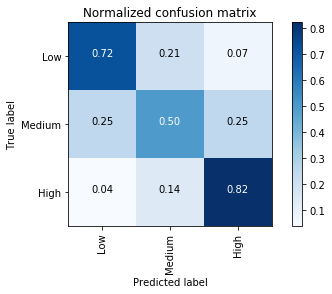

In [334]:
plt.grid(b=False)
cm = metrics.confusion_matrix(y_truth, y_pred_)
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')

# Deep Learning Models:

#### Data Preparation for Deep Leaning Models:

In [367]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM,Conv1D
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization,MaxPooling1D,Flatten
from keras.layers import GRU
import tensorflow as tf

In [368]:
# Importing tensorflow
np.random.seed(42)
tf.set_random_seed(42)
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [369]:
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [380]:
x_train_=np.expand_dims(x_train_,2)
x_cv_=np.expand_dims(x_cv_,2)
x_test_=np.expand_dims(x_test_,2)
y_train=np_utils.to_categorical(y_train_)
y_test=np_utils.to_categorical(y_test_)
y_cv=np_utils.to_categorical(y_cv_)

In [371]:
num_classes=3

In [372]:
def predict_(model,x_test,y_test):
    y_predict = np.asarray(model.predict(x_test))
    print(y_predict.shape)
    y_predict =y_predict.reshape((3,-1)).argmax(axis=0) 
    acc=accuracy_score(y_test, y_predict)
    score=f1_score(y_test, y_predict,average='micro')
    print("The micro F1 score of the model is", score)
    print("The accuracy score of the model is", acc)

In [373]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [374]:
def run_model(model,es_round=5,epoch=30,batch_size=64):
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy',f1_m])
    cb=EarlyStopping(monitor='val_f1_m', min_delta=0, patience=es_round, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.fit(x_train_,y_train,batch_size=64,validation_data=(x_cv_,y_cv),callbacks=[cb],epochs=epoch,verbose=1)
    score=model.evaluate(x_test_,y_test)
    print('Evaluating Test Score..........')
    print("Test Loss:{} ".format(round(score[0],2)))
    print("Test Accuracy:{} %".format(int(round(score[1]*100))))
    print("Test F1 Score:{} ".format(score[2]))
    print('completed.')
    

In [375]:
batch_size=128
timesteps=x_train_.shape[1]
input_dimension=1
n_classes=3

In [384]:
model=Sequential()
model.add(Dense(64,input_shape=(timesteps,input_dimension)))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 41, 64)            128       
_________________________________________________________________
dense_13 (Dense)             (None, 41, 32)            2080      
_________________________________________________________________
dense_14 (Dense)             (None, 41, 3)             99        
Total params: 2,307
Trainable params: 2,307
Non-trainable params: 0
_________________________________________________________________


#### 1 LSTM, 3 Dense layers:

In [165]:
model=Sequential()
model.add(LSTM(32,input_shape=(timesteps,input_dimension)))
model.add(Dense(64,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 195       
Total params: 6,659
Trainable params: 6,659
Non-trainable params: 0
_________________________________________________________________


In [166]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])

In [167]:
es=EarlyStopping(monitor='val_f1_m', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [169]:
history=model.fit(x_train_,y_train,batch_size=64,validation_data=(x_cv_,y_cv),callbacks=[es],epochs=30,verbose=1)


Train on 175000 samples, validate on 75000 samples
Epoch 1/30
175000/175000 [==============================] - 170s 973us/step - loss: 0.6725 - acc: 0.6774 - f1_m: 0.6354 - val_loss: 0.6132 - val_acc: 0.7062 - val_f1_m: 0.6655
Epoch 2/30
175000/175000 [==============================] - 170s 971us/step - loss: 0.6077 - acc: 0.7069 - f1_m: 0.6767 - val_loss: 0.5973 - val_acc: 0.7109 - val_f1_m: 0.6729
Epoch 3/30
175000/175000 [==============================] - 188s 1ms/step - loss: 0.5986 - acc: 0.7099 - f1_m: 0.6817 - val_loss: 0.5978 - val_acc: 0.7084 - val_f1_m: 0.6962
Epoch 4/30
175000/175000 [==============================] - 205s 1ms/step - loss: 0.5927 - acc: 0.7141 - f1_m: 0.6874 - val_loss: 0.5932 - val_acc: 0.7123 - val_f1_m: 0.6985
Epoch 5/30
175000/175000 [==============================] - 213s 1ms/step - loss: 0.5879 - acc: 0.7169 - f1_m: 0.6910 - val_loss: 0.5837 - val_acc: 0.7201 - val_f1_m: 0.6940
Epoch 6/30
175000/175000 [==============================] - 205s 1ms/step -

#### 1 LSTM,2 Dense layers with Dropout and BN:

In [389]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dimension)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add((BatchNormalization()))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 195       
Total params: 6,915
Trainable params: 6,787
Non-trainable params: 128
_________________________________________________________________


In [387]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])

In [391]:
run_model(model,es_round=3,batch_size=256)

Train on 210000 samples, validate on 90000 samples
Epoch 1/30
210000/210000 [==============================] - 119s 568us/step - loss: 0.9464 - acc: 0.6037 - f1_m: 0.6037 - val_loss: 0.9489 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 2/30
210000/210000 [==============================] - 114s 541us/step - loss: 0.9465 - acc: 0.6037 - f1_m: 0.6036 - val_loss: 0.9452 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 3/30
210000/210000 [==============================] - 110s 523us/step - loss: 0.9466 - acc: 0.6037 - f1_m: 0.6035 - val_loss: 0.9444 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 4/30
152419/152419 [==============================] - 23s 150us/step
Evaluating Test Score..........
Test Loss:0.95 
Test Accuracy:60 %
Test F1 Score:0.6030874819752081 
completed.


#### CNN:

#### Model1:

In [190]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(Conv1D(input_dimension,kernel_size=3,padding='same',activation='relu',input_shape=(timesteps, input_dimension)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(128,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv1D(128,3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(64,3,padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 41, 1)             4         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 1)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 13, 128)           512       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 128)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 128)            512       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 4, 128)            49280     
__________

In [194]:
run_model(model)

Train on 175000 samples, validate on 75000 samples
Epoch 1/30
175000/175000 [==============================] - 52s 295us/step - loss: 0.7188 - acc: 0.6391 - f1_m: 0.4709 - val_loss: 0.6808 - val_acc: 0.6821 - val_f1_m: 0.6277
Epoch 2/30
175000/175000 [==============================] - 47s 271us/step - loss: 0.7189 - acc: 0.6521 - f1_m: 0.5414 - val_loss: 0.7199 - val_acc: 0.6037 - val_f1_m: 0.5500
Epoch 3/30
175000/175000 [==============================] - 50s 288us/step - loss: 0.7248 - acc: 0.6394 - f1_m: 0.6021 - val_loss: 0.7114 - val_acc: 0.6037 - val_f1_m: 0.5494
Epoch 4/30
175000/175000 [==============================] - 52s 296us/step - loss: 0.7240 - acc: 0.6443 - f1_m: 0.5567 - val_loss: 0.7003 - val_acc: 0.6536 - val_f1_m: 0.6173
Epoch 5/30
175000/175000 [==============================] - 54s 310us/step - loss: 0.7103 - acc: 0.6574 - f1_m: 0.6420 - val_loss: 0.6889 - val_acc: 0.6751 - val_f1_m: 0.6528
Epoch 6/30
175000/175000 [==============================] - 54s 309us/step

#### Model2:

In [197]:
model = Sequential()
# Configuring the parameters
model.add(Conv1D(input_dimension,kernel_size=3,padding='same',activation='relu',input_shape=(timesteps, input_dimension)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(64,3,padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 41, 1)             4         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 13, 1)             0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 13, 64)            256       
_________________________________________________________________
flatten_4 (Flatten)          (None, 832)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               213248    
_________________________________________________________________
dense_43 (Dense)             (None, 3)                 771       
Total params: 214,279
Trainable params: 214,279
Non-trainable params: 0
_________________________________________________________________


In [198]:
run_model(model)

Train on 175000 samples, validate on 75000 samples
Epoch 1/30
175000/175000 [==============================] - 33s 188us/step - loss: 0.9503 - acc: 0.6035 - f1_m: 0.6000 - val_loss: 0.9719 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 2/30
175000/175000 [==============================] - 32s 182us/step - loss: 0.9498 - acc: 0.6037 - f1_m: 0.6006 - val_loss: 0.9447 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 3/30
175000/175000 [==============================] - 32s 185us/step - loss: 0.9498 - acc: 0.6037 - f1_m: 0.5980 - val_loss: 0.9518 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 4/30
175000/175000 [==============================] - 33s 188us/step - loss: 0.9499 - acc: 0.6037 - f1_m: 0.5987 - val_loss: 0.9499 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 5/30
175000/175000 [==============================] - 34s 195us/step - loss: 0.9497 - acc: 0.6037 - f1_m: 0.5988 - val_loss: 0.9510 - val_acc: 0.6037 - val_f1_m: 0.6037
Epoch 6/30
152419/152419 [==============================] - 20s 133us/step

# Comparison:

In [392]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['model','Type','Micro average f1 score']
x.add_row(['1','random','0.33'])
x.add_row(['2','logistic regression','0.69'])
x.add_row(['3','linear SVM','0.68'])
x.add_row(['4','Random Forest','0.65'])
x.add_row(['5','Light GBM','0.78'])
x.add_row(['6','Majority Voting-LR,RF,LGBM','0.74'])
x.add_row(['7','LSTM','0.71'])
x.add_row(['8','CNN','0.60'])
print(x)

+-------+----------------------------+------------------------+
| model |            Type            | Micro average f1 score |
+-------+----------------------------+------------------------+
|   1   |           random           |          0.33          |
|   2   |    logistic regression     |          0.69          |
|   3   |         linear SVM         |          0.68          |
|   4   |       Random Forest        |          0.65          |
|   5   |         Light GBM          |          0.78          |
|   6   | Majority Voting-LR,RF,LGBM |          0.74          |
|   7   |            LSTM            |          0.71          |
|   8   |            CNN             |          0.60          |
+-------+----------------------------+------------------------+
